<a href="https://colab.research.google.com/github/Pankaj-2003/LLMS-GPT/blob/main/makemore_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [32]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    # print(X)
    Y.append(ix)
    # print(Y)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [22]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [23]:
X.shape , Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

#### Making embeddings for our 27 chars (27,2) , the paper had 27k words which they embedded in a space of 30D , but we will do 2D.
#### And our input to neural net will be indexes.
#### The weight matrix can be C , and input will be index.

In [33]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [30]:
C[X]

tensor([[[-0.1482, -0.3486],
         [-0.1482, -0.3486],
         [-0.1482, -0.3486]],

        [[-0.1482, -0.3486],
         [-0.1482, -0.3486],
         [ 1.2729,  0.2831]],

        [[-0.1482, -0.3486],
         [ 1.2729,  0.2831],
         [-1.3120,  1.7955]],

        ...,

        [[-0.8495,  0.8115],
         [-0.8495,  0.8115],
         [-1.3175,  0.6455]],

        [[-0.8495,  0.8115],
         [-1.3175,  0.6455],
         [-0.8495,  0.8115]],

        [[-1.3175,  0.6455],
         [-0.8495,  0.8115],
         [-0.4391,  0.2781]]])

In [25]:
# embeddings for each alphabet
C = torch.randn((27,2))

In [26]:
C

tensor([[-0.1482, -0.3486],
        [-1.1055, -0.3096],
        [-0.6486, -0.7078],
        [ 0.4480, -0.8168],
        [-0.8853, -0.5056],
        [ 1.2729,  0.2831],
        [-0.2787,  1.2615],
        [-0.2166,  0.3655],
        [ 1.0714, -0.6155],
        [ 0.7984, -1.9375],
        [-0.4544,  0.7601],
        [ 0.4857,  0.8650],
        [ 0.9956, -0.3164],
        [-1.3120,  1.7955],
        [-0.1886, -0.3521],
        [ 0.4705,  0.3874],
        [-0.8782,  2.5877],
        [ 0.4520,  0.3147],
        [ 0.3183,  0.9478],
        [ 0.1205, -0.5388],
        [ 0.9989,  0.6714],
        [-0.2054, -0.0243],
        [ 0.0412,  0.4636],
        [-0.3125, -1.5435],
        [-0.4391,  0.2781],
        [-1.3175,  0.6455],
        [-0.8495,  0.8115]])

In [48]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
lre = torch.linspace(-3 , 0 , 1000)
lrs = 10**lre

In [62]:

# training neural net
lri = []
lossi = []
stepi  = []
# forward pass
for p in parameters:
  p.requires_grad = True

for k in range(30000):
  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))
  X_b = Xtr[ix]
  Y_b = Ytr[ix]
  # forward pass
  emb_x = C[X_b]  # (32, 3 , 2)
  h = torch.tanh(emb_x.view(-1,6) @ W1 + b1)   # (32,100)

  logits = h @ W2 + b2   # (32,27)
  loss = F.cross_entropy(logits, Y_b)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  # lr = lrs[k]
  lr = 0.01
  # update
  for p in parameters:
    p.data += -lr * p.grad
  # track
  # lri.append(lre[k])

  lossi.append(loss.item())
  stepi.append(k)

print(loss.item())

2.338690996170044


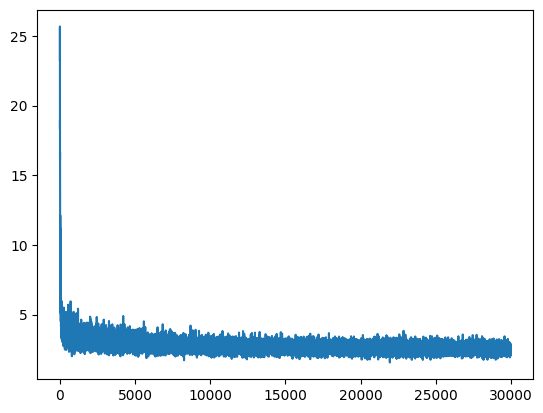

In [50]:

plt.plot(stepi , lossi)

In [63]:
# training split for parameters w and b , validation split  this for hyperparameters  , test split
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss





tensor(2.2313, grad_fn=<NllLossBackward0>)

In [64]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2491, grad_fn=<NllLossBackward0>)

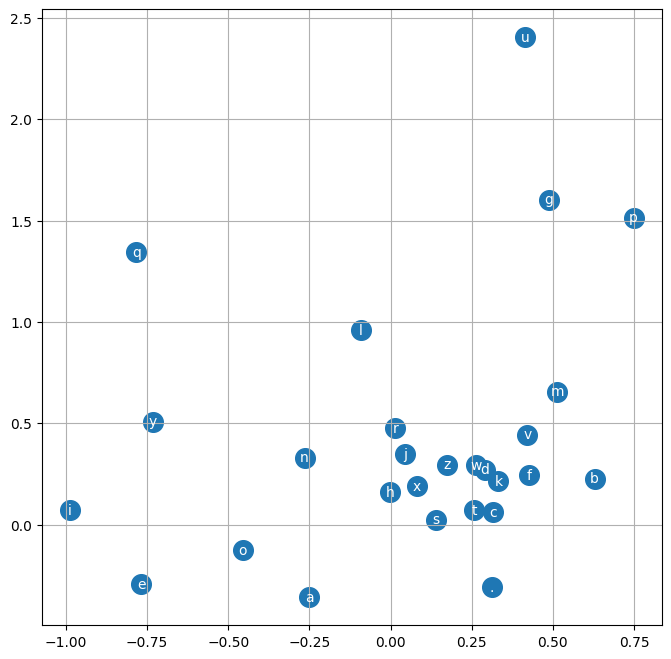

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')